In [1]:
#Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import random

from sklearn.metrics import confusion_matrix

from torch.utils.tensorboard import SummaryWriter

In [2]:
#check pytorch version
print(torch.__version__)
print(torchvision.__version__)

2.0.0+cpu
0.15.1+cpu


In [3]:
transform =transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_set = torchvision.datasets.CIFAR10(root = './data', train=True,  transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 64, shuffle=True)

test_set = torchvision.datasets.CIFAR10(root = './data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [05:30<00:00, 515429.69it/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 32, 32])
torch.Size([64])
labels: tensor([8, 9, 7, 6, 4, 9, 4, 2, 8, 3, 7, 7, 8, 7, 6, 2, 3, 1, 9, 5, 8, 8, 1, 6,
        0, 5, 9, 7, 8, 1, 9, 7, 9, 3, 7, 1, 6, 5, 5, 7, 7, 7, 3, 0, 7, 3, 1, 4,
        5, 8, 4, 2, 9, 8, 8, 6, 9, 0, 0, 3, 5, 3, 6, 6])


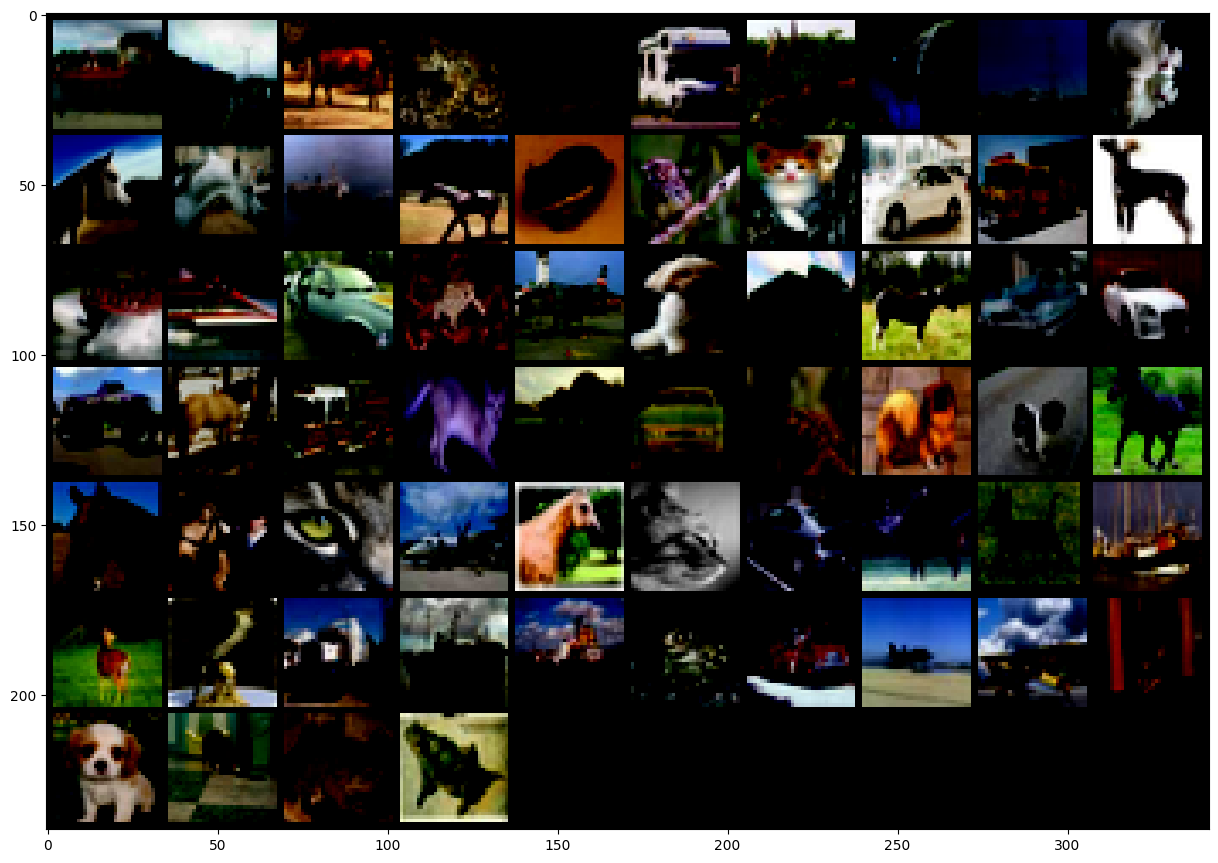

In [4]:
batch = next(iter(train_loader))

images, labels = batch

print(images.shape)
print(labels.shape)
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15,15))
plt.imshow(grid.permute(1,2,0))

print('labels:', labels)

In [5]:
class Network(nn.Module):
  def __init__(self):
    super(Network,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, padding=2, stride=1)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=4, padding=1, stride=1)
    self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding=2, stride=1)
    self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, padding=1, stride=1)

    self.fc1 = nn.Linear(in_features=256*3*3, out_features=1024)
    self.fc2 = nn.Linear(in_features=1024, out_features=512)
    self.out = nn.Linear(in_features=512, out_features=10)

  def forward(self, t):
    #Layer 1
    t = t
    #Layer 2
    t = self.conv1(t)
    t = F.relu(t)
    t = self.conv2(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)#output shape : (64,16,16)
    #Layer 3
    t = self.conv3(t)
    t = F.relu(t)
    t = self.conv4(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)#output shape : (256,8,8)
    #Layer 4
    t = self.conv5(t)
    t = F.relu(t)
    t = self.conv6(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)#output shape : (1024,3,3)

    t = t.reshape(-1, 256*3*3)
    t = self.fc1(t)
    t = F.relu(t)#output shape : (1,120)
    #Layer 5
    t = self.fc2(t)
    t = F.relu(t)#output shape : (1, 84)
    #Layer 6/ Output Layer
    t = self.out(t)#output shape : (1,10)

    return t
network = Network()

In [6]:
optimizer = optim.NAdam(network.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, momentum_decay=0.01, foreach=None, differentiable=False)

In [7]:
for epoch in range(10):

  total_correct = 0
  total_loss = 0
  for batch in train_loader: #Get batch
    images, labels = batch #Unpack the batch into images and labels
 
    preds = network(images) #Pass batch
    loss = F.cross_entropy(preds, labels) #Calculate Loss

    optimizer.zero_grad()
    loss.backward() #Calculate gradients
    optimizer.step() #Update weights

    total_loss += loss.item()
    total_correct += preds.argmax(dim=1).eq(labels).sum().item()
    
  print('epoch:', epoch, "total_correct:", total_correct, "loss:", total_loss)

print('>>> Training Complete >>>')

epoch: 0 total_correct: 19262 loss: 1283.3428757190704
epoch: 1 total_correct: 32089 loss: 786.7577801048756
epoch: 2 total_correct: 37538 loss: 563.0152064263821
epoch: 3 total_correct: 40513 loss: 431.0723205059767
epoch: 4 total_correct: 42463 loss: 337.9784484654665
epoch: 5 total_correct: 44191 loss: 259.5952870026231
epoch: 6 total_correct: 45482 loss: 200.45164040848613
epoch: 7 total_correct: 46482 loss: 160.66590633802116
epoch: 8 total_correct: 47193 loss: 131.39604767877609
epoch: 9 total_correct: 47726 loss: 105.34993788413703
>>> Training Complete >>>


In [8]:
PATH = './cifar_net.pth'
torch.save(network.state_dict(), PATH)

In [9]:
network = Network()
network.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [10]:
@torch.no_grad()
def get_all_preds(model, loader):
  all_preds = torch.tensor([])
  for batch in loader:
    images, labels = batch

    preds = model(images)
    all_preds = torch.cat((all_preds, preds) ,dim=0)

  return all_preds

In [11]:
test_preds = get_all_preds(network, test_loader)
actual_labels = torch.Tensor(test_set.targets)
preds_correct = test_preds.argmax(dim=1).eq(actual_labels).sum().item()

print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(test_set))

total correct: 7903
accuracy: 0.7903


In [12]:
random_training_acc = [random.uniform(0.1,0.98) for _ in range(100)]
random_validation_acc = [random.uniform(0.1,0.98) for _ in range(100)]
random_training_acc.sort()
random_validation_acc.sort()
epochs = np.arange(0, 100)

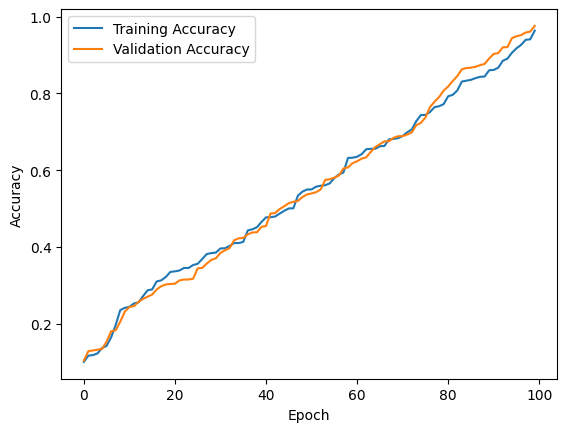

In [13]:
# Plot the training accuracy and validation accuracy
plt.plot(epochs, random_training_acc, label='Training Accuracy')
plt.plot(epochs, random_validation_acc, label='Validation Accuracy')

# Add a legend and axis labels
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Show the plot
plt.show()

In [14]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[840  15  36  18  20   3   8   5  29  26]
 [  4 909   4   2   2   2   3   1  13  60]
 [ 64   5 649  49  94  53  59  16   8   3]
 [ 20   8  36 576  80 172  47  35   9  17]
 [ 19   2  35  41 788  28  37  41   3   6]
 [ 13   6  36  98  47 731  17  46   2   4]
 [  4   3  28  67  29  22 841   2   3   1]
 [ 27   3  16  27  59  39  11 808   1   9]
 [ 64  14   5  12   3   3   8   3 863  25]
 [ 15  49   4   7   1   3   4   5  14 898]]


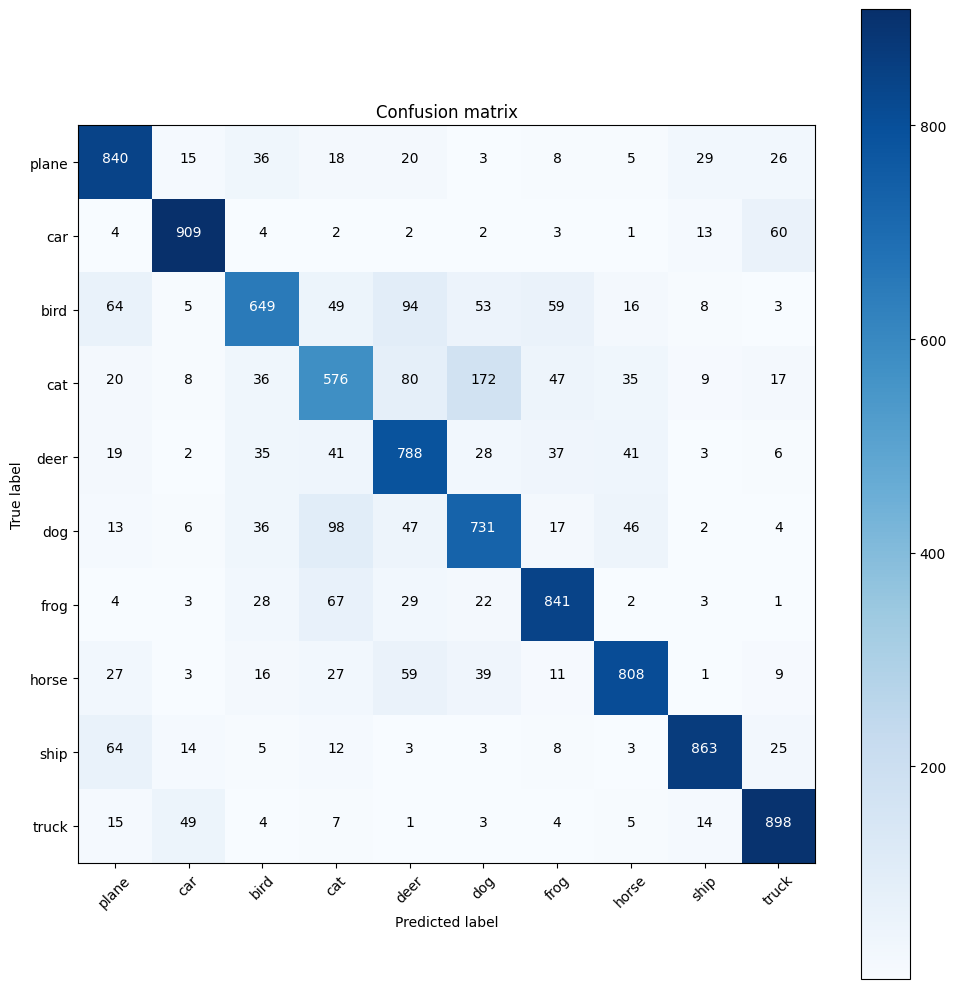

In [15]:
cm = confusion_matrix(test_set.targets, test_preds.argmax(dim=1))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes)